ResNetの転移学習<br>
・学習済みモデルをベースに、最終の出力層のみ付け替えて学習させる<br>
・出力層に近いパラメータのみ学習させる<br>
（入力層に近い部分のパラメータは学習させない）

In [0]:

import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)


In [0]:
#resnet18のモデルをロード
#学習済みパラメータをダウンロード
use_pretrained = True
net = models.resnet18(pretrained=use_pretrained)
print(net)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 195MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
import os
import urllib.request
import zipfile

# PyTorchのチュートリアルからアリとハチの画像をダウンロード
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

# フォルダ「data」が存在しない場合は作成する
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
save_path = os.path.join(data_dir, "hymenoptera_data.zip")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)

    # ZIPファイルを読み込み
    zip = zipfile.ZipFile(save_path)
    zip.extractall(data_dir)  # ZIPを解凍
    zip.close()  # ZIPファイルをクローズ

    # ZIPファイルを消去
    os.remove(save_path)

In [0]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる
class ImageTransform():
  def __init__(self, resize, mean, std):
    self.data_transform = {
        'train' : transforms.Compose([
            transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),　#scaleで指定した0.5から1.0の大きさで画像を拡大・縮小し、アスペクト比を3/4から4/3の間のいずれかで変更して画像を横もしくは縦に引き伸ばし、最後にresizeで指定した大きさで画像を切り出す
            transforms.RandomHorizontalFlip(), #画像の左右を50%の確率で反転させる
            transforms.ToTensor(),
            transforms.Normalize(mean, std)                                      
        ]),
        'val' : transforms.Compose([
             transforms.Resize(resize),
             transforms.CenterCrop(resize),
             transforms.ToTensor(),
             transforms.Normalize(mean, std)                       
        ])
    }
  
  def __call__(self, img, phase='train'):
    return self.data_transform[phase](img)

In [0]:
#　http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n02814533から持ってきた
from urllib import request

url="http://www.autoweek.nl/images/480/e/52e07211aa41ddd948a4fffc8aec126e.jpg"
with request.urlopen(url) as response:
    img = response.read() 

with open('67227983_ce131cca2a.jpg', 'wb') as f:
    f.write(img)

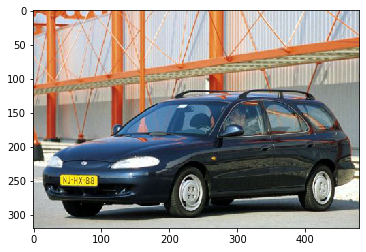

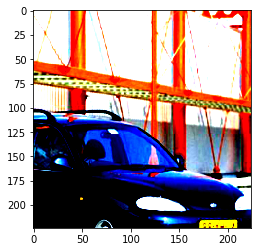

In [0]:
# 訓練時の画像前処理の動作を確認
# 実行するたびに処理結果の画像が変わる

image_file_path = '67227983_ce131cca2a.jpg'
img = Image.open(image_file_path)

plt.imshow(img)
plt.show()

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase='train')

img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0 , 1)
plt.imshow(img_transformed)
plt.show()

In [0]:
# アリとハチの画像へのファイルパスのリストを作成する

def make_datapath_list(phase="train"):

  rootpath = "./data/hymenoptera_data/"
  target_path = osp.join(rootpath+phase+'/**/*.jpg')

  path_list = []

  for path in glob.glob(target_path):
    path_list.append(path)
  
  return path_list

train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

train_list
val_list

['./data/hymenoptera_data/val/ants/205398178_c395c5e460.jpg',
 './data/hymenoptera_data/val/ants/Hormiga.jpg',
 './data/hymenoptera_data/val/ants/412436937_4c2378efc2.jpg',
 './data/hymenoptera_data/val/ants/212100470_b485e7b7b9.jpg',
 './data/hymenoptera_data/val/ants/239161491_86ac23b0a3.jpg',
 './data/hymenoptera_data/val/ants/445356866_6cb3289067.jpg',
 './data/hymenoptera_data/val/ants/Ant-1818.jpg',
 './data/hymenoptera_data/val/ants/518746016_bcc28f8b5b.jpg',
 './data/hymenoptera_data/val/ants/94999827_36895faade.jpg',
 './data/hymenoptera_data/val/ants/10308379_1b6c72e180.jpg',
 './data/hymenoptera_data/val/ants/573151833_ebbc274b77.jpg',
 './data/hymenoptera_data/val/ants/147542264_79506478c2.jpg',
 './data/hymenoptera_data/val/ants/751649788_78dd7d16ce.jpg',
 './data/hymenoptera_data/val/ants/8398478_50ef10c47a.jpg',
 './data/hymenoptera_data/val/ants/152286280_411648ec27.jpg',
 './data/hymenoptera_data/val/ants/477437164_bc3e6e594a.jpg',
 './data/hymenoptera_data/val/ants/50

In [0]:
# アリとハチの画像のDatasetを作成する

class HymenopteraDataset(data.Dataset):

  def __init__(self, file_list, transform=None, phase='train'):
    self.file_list = file_list
    self.transform = transform
    self.phase = phase
  
  def __len__(self):
    return len(self.file_list)

  def __getitem__(self, index):
    img_path = self.file_list[index]
    img = Image.open(img_path)

    img_transformed = self.transform(img, self.phase)

    if self.phase == "train":
      label = img_path[30:34]
    elif self.phase == "val":
      label = img_path[28:32]
    
    if label == "ants":
      label = 0
    elif label == "bees":
      label = 1
    
    return img_transformed, label
  

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_dataset = HymenopteraDataset(
  file_list = train_list, transform=ImageTransform(size, mean, std), phase='train')
  
val_dataset = HymenopteraDataset(
  file_list = val_list, transform=ImageTransform(size, mean, std), phase='val')
  
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


In [0]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

batch_iterator = iter(dataloaders_dict["train"])
inputs, labels = next(batch_iterator)
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 1, 1, 1])


In [0]:
#学習済みの重みをロードし、訓練モードに設定

use_pretrained = True
net = models.resnet18(pretrained=use_pretrained)
#(fc): Linear(in_features=512, out_features=1000, bias=True)
net.fc = nn.Linear(in_features=512, out_features=2)

net.train()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
criterion = nn.CrossEntropyLoss()

In [0]:
params_to_update = []

update_param_names = ["fc.weight", "fc.bias"]

for name, param in net.named_parameters():
  if name in update_param_names:
    param.requires_grad = True #パラメーターを更新する
    params_to_update.append(param)
    print(name)
  else:
    param.requires_grad = False #パラメーターを固定し、更新しない

print("----------------")
print(params_to_update)

fc.weight
fc.bias
----------------
[Parameter containing:
tensor([[-0.0178,  0.0402,  0.0354,  ..., -0.0323, -0.0302, -0.0093],
        [-0.0040, -0.0157,  0.0345,  ...,  0.0105, -0.0392, -0.0191]],
       requires_grad=True), Parameter containing:
tensor([-0.0260,  0.0052], requires_grad=True)]


In [0]:
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

In [0]:
# モデルを学習させる関数

def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-------------')

    for phase in ['train' , 'val']:
      if phase == 'train':
        net.train()
      else:
        net.eval()
      
      epoch_loss = 0.0
      epoch_corrects = 0

      if(epoch == 0) and (phase == 'train'):
        continue
      
      for inputs, labels in tqdm(dataloaders_dict[phase]):

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'): #学習時のみ勾配を計算させる
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          _, preds = torch.max(outputs, 1)

          if phase == 'train':
            loss.backward()
            optimizer.step()
          
          epoch_loss += loss.item() * inputs.size(0)
          epoch_corrects += torch.sum(preds == labels.data)
      
      epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
      epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

In [0]:
num_epochs = 20
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/20
-------------


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.6127 Acc: 0.6863
Epoch 2/20
-------------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.5285 Acc: 0.7819


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.4471 Acc: 0.7843
Epoch 3/20
-------------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.3763 Acc: 0.8642


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.3367 Acc: 0.8758
Epoch 4/20
-------------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.2928 Acc: 0.9095


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.2908 Acc: 0.9085
Epoch 5/20
-------------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.2404 Acc: 0.9300


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.2596 Acc: 0.9216
Epoch 6/20
-------------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.2219 Acc: 0.9424


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.2519 Acc: 0.9216
Epoch 7/20
-------------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.2127 Acc: 0.9342


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.2293 Acc: 0.9281
Epoch 8/20
-------------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.1963 Acc: 0.9342


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.2526 Acc: 0.9085
Epoch 9/20
-------------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.1749 Acc: 0.9424


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.2166 Acc: 0.9281
Epoch 10/20
-------------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.1620 Acc: 0.9547


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.2235 Acc: 0.9346
Epoch 11/20
-------------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.1795 Acc: 0.9424


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.2137 Acc: 0.9346
Epoch 12/20
-------------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.1315 Acc: 0.9794


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.2196 Acc: 0.9346
Epoch 13/20
-------------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.1335 Acc: 0.9630


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.2093 Acc: 0.9346
Epoch 14/20
-------------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.1944 Acc: 0.9383


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.2201 Acc: 0.9281
Epoch 15/20
-------------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.1742 Acc: 0.9465


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.1976 Acc: 0.9346
Epoch 16/20
-------------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.1208 Acc: 0.9588


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.2079 Acc: 0.9346
Epoch 17/20
-------------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.1492 Acc: 0.9506


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.2090 Acc: 0.9281
Epoch 18/20
-------------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.1247 Acc: 0.9630


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.1940 Acc: 0.9281
Epoch 19/20
-------------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.1744 Acc: 0.9342


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.2094 Acc: 0.9346
Epoch 20/20
-------------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.1461 Acc: 0.9547


100%|██████████| 5/5 [00:08<00:00,  1.73s/it]

val Loss: 0.1970 Acc: 0.9412


ファインチューニング

In [0]:
use_pretrained = True

net = models.resnet18(pretrained=use_pretrained)
#(fc): Linear(in_features=512, out_features=1000, bias=True)
net.fc = nn.Linear(in_features=512, out_features=2)

net.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
criterion = nn.CrossEntropyLoss()

In [0]:
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []
params_to_update_4 = []
params_to_update_5 = []
params_to_update_6 = []

update_param_names_1 = ["conv1.weight", "bn1.weight", "bn1.bias"]
update_param_names_2 = ["layer1"]
update_param_names_3 = ["layer2"]
update_param_names_4 = ["layer3"]
update_param_names_5 = ["layer4"]
update_param_names_6 = ["fc.weight","fc.bias"]

for name, param in net.named_parameters():

  if name in update_param_names_1:
    param.requires_grad = True
    params_to_update_1.append(param)
    print("params_to_update_1に格納:", name)

  elif update_param_names_2[0] in name:
    param.requires_grad = True
    params_to_update_2.append(param)
    print("params_to_update_2に格納:", name)

  elif update_param_names_3[0] in name:
    param.requires_grad = True
    params_to_update_3.append(param)
    print("params_to_update_3に格納:", name)

  elif update_param_names_4[0] in name:
    param.requires_grad = True
    params_to_update_4.append(param)
    print("params_to_update_4に格納:", name)

  elif update_param_names_5[0] in name:
    param.requires_grad = True
    params_to_update_5.append(param)
    print("params_to_update_5に格納:", name)

  elif name in update_param_names_6:
    param.requires_grad = True
    params_to_update_6.append(param)
    print("params_to_update_6に格納：", name)
  
  else:
    param.requires_grad = False
    print("勾配計算なし。学習しない:", name)

params_to_update_1に格納: conv1.weight
params_to_update_1に格納: bn1.weight
params_to_update_1に格納: bn1.bias
params_to_update_2に格納: layer1.0.conv1.weight
params_to_update_2に格納: layer1.0.bn1.weight
params_to_update_2に格納: layer1.0.bn1.bias
params_to_update_2に格納: layer1.0.conv2.weight
params_to_update_2に格納: layer1.0.bn2.weight
params_to_update_2に格納: layer1.0.bn2.bias
params_to_update_2に格納: layer1.1.conv1.weight
params_to_update_2に格納: layer1.1.bn1.weight
params_to_update_2に格納: layer1.1.bn1.bias
params_to_update_2に格納: layer1.1.conv2.weight
params_to_update_2に格納: layer1.1.bn2.weight
params_to_update_2に格納: layer1.1.bn2.bias
params_to_update_3に格納: layer2.0.conv1.weight
params_to_update_3に格納: layer2.0.bn1.weight
params_to_update_3に格納: layer2.0.bn1.bias
params_to_update_3に格納: layer2.0.conv2.weight
params_to_update_3に格納: layer2.0.bn2.weight
params_to_update_3に格納: layer2.0.bn2.bias
params_to_update_3に格納: layer2.0.downsample.0.weight
params_to_update_3に格納: layer2.0.downsample.1.weight
params_to_update_3に格

In [0]:
optimizer = optim.SGD([
  {'params': params_to_update_1, 'lr': 1e-4},
  {'params': params_to_update_2, 'lr': 5e-4},
  {'params': params_to_update_3, 'lr': 5e-4},
  {'params': params_to_update_4, 'lr': 5e-4},
  {'params': params_to_update_5, 'lr': 5e-4},
  {'params': params_to_update_6, 'lr': 1e-3}
], momentum=0.9)

In [0]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print("使用デバイス：", device)

  net.to(device)

  torch.backends.cudnn.benchmark = True

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('----------')

    for phase in ['train', 'val']:
      if phase == 'train':
        net.train()
      else:
        net.eval()
      
      epoch_loss = 0.0
      epoch_corrects = 0

      if (epoch == 0) and (phase == 'train'):
        continue
      
      for inputs, labels in tqdm(dataloaders_dict[phase]):

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          _, preds = torch.max(outputs, 1)

          if phase == 'train':
            loss.backward()
            optimizer.step()
          
          epoch_loss += loss.item() * inputs.size(0)
          epoch_corrects += torch.sum(preds == labels.data)
      
      epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
      epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

In [0]:
num_epochs = 20
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

使用デバイス： cuda:0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/20
----------


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.9451 Acc: 0.3922
Epoch 2/20
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.8214 Acc: 0.4527


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.5868 Acc: 0.7059
Epoch 3/20
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.5476 Acc: 0.7284


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.3621 Acc: 0.8889
Epoch 4/20
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.3553 Acc: 0.8560


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.2656 Acc: 0.9281
Epoch 5/20
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.2472 Acc: 0.9177


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.2543 Acc: 0.9085
Epoch 6/20
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.1691 Acc: 0.9588


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.2103 Acc: 0.9216
Epoch 7/20
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.1470 Acc: 0.9547


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.1973 Acc: 0.9412
Epoch 8/20
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.1386 Acc: 0.9547


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.1981 Acc: 0.9412
Epoch 9/20
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.1047 Acc: 0.9794


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.1829 Acc: 0.9346
Epoch 10/20
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.1042 Acc: 0.9712


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.1793 Acc: 0.9412
Epoch 11/20
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.0885 Acc: 0.9712


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.1847 Acc: 0.9412
Epoch 12/20
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.1086 Acc: 0.9794


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.1768 Acc: 0.9412
Epoch 13/20
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.0636 Acc: 0.9959


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.1826 Acc: 0.9346
Epoch 14/20
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.0924 Acc: 0.9835


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.1777 Acc: 0.9346
Epoch 15/20
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.0712 Acc: 0.9835


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.1745 Acc: 0.9412
Epoch 16/20
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.0889 Acc: 0.9794


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.1704 Acc: 0.9412
Epoch 17/20
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.0627 Acc: 0.9877


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.1718 Acc: 0.9412
Epoch 18/20
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.0473 Acc: 0.9959


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.1724 Acc: 0.9412
Epoch 19/20
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.0457 Acc: 1.0000


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.1689 Acc: 0.9412
Epoch 20/20
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.0454 Acc: 0.9918


100%|██████████| 5/5 [00:01<00:00,  3.88it/s]

val Loss: 0.1692 Acc: 0.9412
